In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

class CameraPose:

    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat

    def __str__(self):
        return 'Metadata : ' + ' '.join(map(str, self.metadata)) + '\n' + \
            "Pose : " + "\n" + np.array_str(self.pose)


def read_trajectory(filename):
    traj = []
    with open(filename, 'r') as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=' \t')
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj

redwood_rgbd = o3d.data.SampleRedwoodRGBDImages()
camera_poses = read_trajectory(redwood_rgbd.odometry_log_path)

volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

volume = o3d.pipelines.integration.UniformTSDFVolume(
    length=0.3,
    resolution=40,
    sdf_trunc=4*0.3,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.NoColor)

for i in range(len(camera_poses)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(redwood_rgbd.color_paths[i])
    depth = o3d.io.read_image(redwood_rgbd.depth_paths[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    volume.integrate(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
        np.linalg.inv(camera_poses[i].pose))

print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh],
                                  front=[0.5297, -0.1873, -0.8272],
                                  lookat=[2.0712, 2.0312, 1.7251],
                                  up=[-0.0558, -0.9809, 0.1864],
                                  zoom=0.47)



Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.
Extract a triangle mesh from the volume and visualize it.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [ ]:
from math import cos, sin

class TSDFVolume(object):
    """Integration of multiple depth images using a TSDF."""

    def __init__(self, size, resolution):
        self.size = size
        self.resolution = resolution
        self.voxel_size = self.size / self.resolution
        self.sdf_trunc = 4 * self.voxel_size

        self.volume = o3d.pipelines.integration.UniformTSDFVolume(
            length=self.size,
            resolution=self.resolution,
            sdf_trunc=self.sdf_trunc,
            color_type=o3d.pipelines.integration.TSDFVolumeColorType.NoColor,
        )

    def integrate(self, depth_img, intrinsic, extrinsic):
        """
        Args:
            depth_img: The depth image.
            intrinsic: The intrinsic parameters of a pinhole camera model.
            extrinsics: The transform from the TSDF to camera coordinates, T_eye_task.
        """
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(np.empty_like(depth_img)),
            o3d.geometry.Image(depth_img),
            depth_scale=1.0,
            depth_trunc=2.0,
            convert_rgb_to_intensity=False,
        )

        intrinsic = o3d.camera.PinholeCameraIntrinsic(
            width=intrinsic.width,
            height=intrinsic.height,
            fx=intrinsic.fx,
            fy=intrinsic.fy,
            cx=intrinsic.cx,
            cy=intrinsic.cy,
        )

        extrinsic = extrinsic.as_matrix()

        self.volume.integrate(rgbd, intrinsic, extrinsic)

    def get_grid(self):
        # TODO(mbreyer) very slow (~35 ms / 50 ms of the whole pipeline)
        shape = (1, self.resolution, self.resolution, self.resolution)
        tsdf_grid = np.zeros(shape, dtype=np.float32)
        voxels = self._volume.extract_voxel_grid().get_voxels()
        for voxel in voxels:
            i, j, k = voxel.grid_index
            tsdf_grid[0, i, j, k] = voxel.color[0]
        return tsdf_grid

    def get_cloud(self):
        return self._volume.extract_point_cloud()


def create_tsdf(size, resolution, depth_imgs, intrinsic, extrinsics):
    tsdf = TSDFVolume(size, resolution)
    for i in range(depth_imgs.shape[0]):
        extrinsic = extrinsics[i]
        tsdf.integrate(depth_imgs[i], intrinsic, extrinsic)
    return tsdf


def camera_on_sphere(origin, radius, theta, phi):
    eye = np.r_[
        radius * sin(theta) * cos(phi),
        radius * sin(theta) * sin(phi),
        radius * cos(theta),
    ]
    target = np.array([0.0, 0.0, 0.0])
    up = np.array([0.0, 0.0, 1.0])  # this breaks when looking straight down
    return look_at(eye, target, up) * origin.inverse()

def look_at(cls, eye, center, up):
    """Initialize with a LookAt matrix.

    Returns:
        T_eye_ref, the transform from camera to the reference frame, w.r.t.
        which the input arguments were defined.
    """
    eye = np.asarray(eye)
    center = np.asarray(center)

    forward = center - eye
    forward /= np.linalg.norm(forward)

    right = np.cross(forward, up)
    right /= np.linalg.norm(right)

    up = np.asarray(up) / np.linalg.norm(up)
    up = np.cross(right, forward)

    m = np.eye(4, 4)
    m[:3, 0] = right
    m[:3, 1] = -up
    m[:3, 2] = forward
    m[:3, 3] = eye

    return cls.from_matrix(m).inverse()

/home/yilong/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


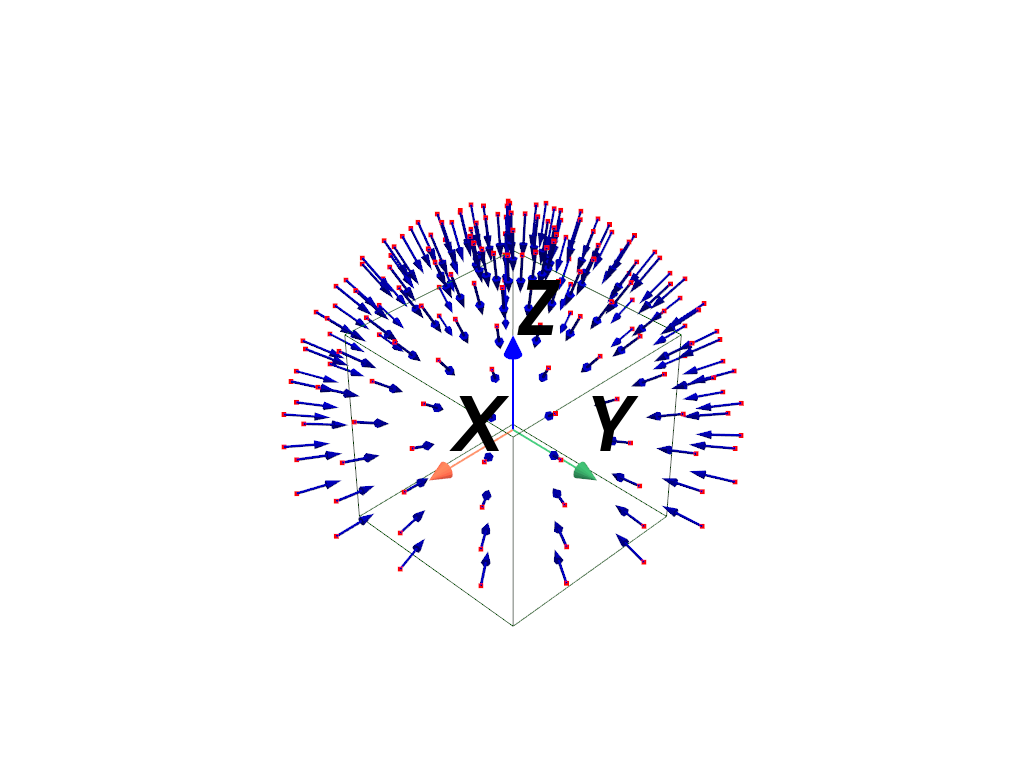

In [ ]:
import numpy as np
import pyvista as pv

def look_at(eye, center, up):
    eye = np.asarray(eye)
    center = np.asarray(center)
    up = np.asarray(up)
    
    forward = center - eye
    forward /= np.linalg.norm(forward)
    
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    
    up = np.cross(right, forward)
    
    m = np.eye(4)
    m[:3, 0] = right
    m[:3, 1] = up
    m[:3, 2] = -forward
    m[:3, 3] = eye
    
    return np.linalg.inv(m)

def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])

class BoundingBox:
    def __init__(self, center, size):
        self.center = np.array(center)
        self.size = np.array(size)

class ViewHalfSphere:
    def __init__(self, bbox, min_z_dist):
        self.center = bbox.center
        self.r = 0.5 * bbox.size[2] + min_z_dist

    def get_view(self, theta, phi):
        eye = self.center + spherical_to_cartesian(self.r, theta, phi)
        up = np.array([0.0, 0.0, 1.0])
        return look_at(eye, self.center, up)

# Visualization setup
bbox = BoundingBox(center=[0, 0, 0], size=[2, 2, 2])
viewer = ViewHalfSphere(bbox, min_z_dist=1)

theta_vals = np.linspace(0, np.pi / 2, 10)  # Hemisphere angles
phi_vals = np.linspace(0, 2 * np.pi, 20)

eye_positions = []
for theta in theta_vals:
    for phi in phi_vals:
        eye_positions.append(viewer.center + spherical_to_cartesian(viewer.r, theta, phi))

eye_positions = np.array(eye_positions)

# Create PyVista plotter
plotter = pv.Plotter()

# Add coordinate axes at the center
plotter.add_axes_at_origin()

# Add viewing positions as points
plotter.add_points(eye_positions, color='red', point_size=5)

# Add arrows showing view directions
for eye in eye_positions:
    direction = bbox.center - eye
    plotter.add_arrows(eye[np.newaxis, :], direction[np.newaxis, :], 
                      mag=0.2, color='blue')

# Add the bounding box
box = pv.Cube(center=bbox.center, x_length=bbox.size[0], 
             y_length=bbox.size[1], z_length=bbox.size[2])
plotter.add_mesh(box, style='wireframe', color='green')

# Show the plot
plotter.show()






In [30]:
eye_positions.shape

(200, 3)